# Recommender System

Um sistema de recomendação é uma subclasse de sistema de filtragem de informações que busca prever a "classificação" ou "preferência" que um usuário daria a um item.

Neste notebook, veremos como podemos construir um sistema de recomendação usando a biblioteca PyTorch.

Primeiramente vamos importar as bibliotecas necessárias:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

Faremos o download dos dados.

Estamos usando o conjunto de dados [MovieLens](https://grouplens.org/datasets/movielens/).

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2021-06-22 20:32:24--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  46.8MB/s    in 4.4s    

2021-06-22 20:32:29 (42.8 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



Descompactamos o arquivo que fizemos download:

In [ ]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


Vejamos os arquivos que temos disponíveis:

In [ ]:
!ls

ml-20m	ml-20m.zip  sample_data


Carregamos as avaliações de filmes em um DataFrame pandas:

In [ ]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


A seguir vamos setar um novo ID de usuário:

In [ ]:
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

A seguir vamos setar um novo ID de filme:

In [ ]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

Obtemos ID's de usuário, ID's de filme e avaliações como arrays separados:

In [ ]:
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

Obtemos o número de usuários e o número de filmes:

In [ ]:
N = len(set(user_ids))
M = len(set(movie_ids))

Setamos a embedding dimension:

In [ ]:
D = 10

Construímos a Rede Neural (Modelo):

In [ ]:
class Model(nn.Module):
    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim

        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2 * self.D, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

        # set the weights since N(0, 1) leads to poor results
        self.u_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
        self.m_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.M, self.D) * 0.01))

    def forward(self, u, m):
        u = self.u_emb(u) # output is (num_samples, D)
        m = self.m_emb(m) # output is (num_samples, D)

        # merge
        out = torch.cat((u, m), 1) # output is (num_samples, 2D)

        # ANN
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

Selecionamos o dispositivo de processamento:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Instanciamos o modelo:

In [ ]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

Definimos a função Loss e o Optimizer:

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

Criamos uma função para encapsular o loop de treinamento:

In [ ]:
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
    train_users, train_movies, train_ratings = train_data
    test_users, test_movies, test_ratings = test_data

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    # batches per epoch
    Ntrain = len(train_users)
    batches_per_epoch = int(np.ceil(Ntrain / bs))

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []

        # shuffle each batch
        train_users, train_movies, train_ratings = shuffle(
            train_users, train_movies, train_ratings
        )

        for j in range(batches_per_epoch):
            # get the batch
            users = train_users[j*bs:(j+1)*bs]
            movies = train_movies[j*bs:(j+1)*bs]
            targets = train_ratings[j*bs:(j+1)*bs]

            # conver to tensor
            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)

            # reshape targets
            targets = targets.view(-1, 1).float()

            # move data to GPU
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        # we could do this if the test set size was manageable
        # test_outputs = model(test_users, test_movies)
        # test_loss = criterion(test_outputs, test_ratings).item()
        test_loss = []
        for j in range(int(np.ceil(len(test_users) / bs))):
            # get the batch
            users = test_users[j*bs:(j+1)*bs]
            movies = test_movies[j*bs:(j+1)*bs]
            targets = test_ratings[j*bs:(j+1)*bs]

            # conver to tensor
            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)

            # reshape targets
            targets = targets.view(-1, 1).float()

            # move data to GPU
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            outputs = model(users, movies)
            loss = criterion(outputs, targets).item()
            test_loss.append(loss)
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
                f'Test Loss: {test_loss:.4f}, Duration: {dt}')

    return train_losses, test_losses

Embaralhamos os dados na ordem correspondente:

In [ ]:
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

Treinamos o modelo:

In [ ]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd2(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    10)

Epoch 1/10, Train Loss: 0.7389, Test Loss: 0.6955, Duration: 0:00:41.870735
Epoch 2/10, Train Loss: 0.6703, Test Loss: 0.6668, Duration: 0:00:41.844064
Epoch 3/10, Train Loss: 0.6378, Test Loss: 0.6507, Duration: 0:00:41.498121
Epoch 4/10, Train Loss: 0.6155, Test Loss: 0.6406, Duration: 0:00:41.889691
Epoch 5/10, Train Loss: 0.5994, Test Loss: 0.6324, Duration: 0:00:41.638929
Epoch 6/10, Train Loss: 0.5867, Test Loss: 0.6298, Duration: 0:00:41.502983
Epoch 7/10, Train Loss: 0.5764, Test Loss: 0.6286, Duration: 0:00:41.950145
Epoch 8/10, Train Loss: 0.5684, Test Loss: 0.6269, Duration: 0:00:41.597173
Epoch 9/10, Train Loss: 0.5622, Test Loss: 0.6275, Duration: 0:00:41.598991
Epoch 10/10, Train Loss: 0.5573, Test Loss: 0.6260, Duration: 0:00:41.603273


Plotamos a loss de treinamento e teste por iteração:

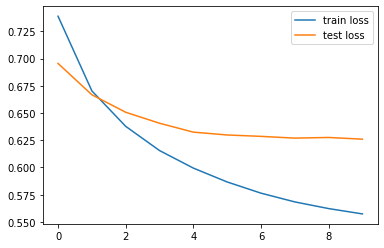

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend();

## Fazendo Previsões

Vejamos agora como podemos usar o nosso modelo para fazer previsões.

Suponha que desejamos encontrar recomendações para o usuário cujo id é 1 (user_id = 1).

Primeiro, encontramos todos os ID's de filme (movie_ids) para os filmes que esse usuário não assistiu:

In [ ]:
watched_movie_ids = df[df.new_user_id == 1].new_movie_id.values
watched_movie_ids

array([   2,   61,   69,  108,  239,  257,  263,  465,  476,  537,  583,
        874,  891,  907, 1098, 1171, 1184, 1188, 1221, 1231, 1242, 1298,
       1326, 1494, 1528, 1616, 1684, 1881, 1885, 1886, 1887, 1888, 1889,
       1890, 1902, 2206, 2369, 2370, 2705, 2772, 2862, 2865, 3063, 3072,
       3086, 3361, 3423, 3443, 3464, 3474, 3612, 3662, 3824, 3825, 3830,
       3833, 3834, 3835, 3837, 3843, 3865], dtype=int16)

In [ ]:
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()

Quantos filmes em potencial temos para recomendar para este usuário?

In [ ]:
potential_movie_ids.shape

(26683,)

In [ ]:
len(set(potential_movie_ids))

26683

Vamos repetir o id do usuário este número potencial de vezes:

In [ ]:
user_id_to_recommend = np.ones_like(potential_movie_ids)

Convertemos para Torch Tensor e movemos os dados para o dispositivo de processamento disponível:

In [ ]:
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

E então podemos obter previsões:

In [ ]:
with torch.no_grad():
    predictions = model(t_user_ids, t_movie_ids)

Convertemos as previsões para NumPy:

In [ ]:
predictions_np = predictions.cpu().numpy().flatten()

Obtemos os índices ordenados (ordem descendente) para as previsões:

In [ ]:
sort_idx = np.argsort(-predictions_np)

In [ ]:
print(sort_idx)

[ 5204  5063 11271 ...  8583  6543  8795]


Por fim, apresentamos os TOP 10 candidatos a serem recomendados:

In [ ]:
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
    print("movie:", movie, "score:", score)

movie: 15188 score: 2.600116
movie: 7563 score: 2.5426302
movie: 19124 score: 2.5201933
movie: 315 score: 2.508326
movie: 17016 score: 2.5077925
movie: 17019 score: 2.485153
movie: 20780 score: 2.4806252
movie: 16241 score: 2.4800231
movie: 9159 score: 2.4762163
movie: 10901 score: 2.4757345
